In [105]:
# imports for the practice (you can add more if you need)
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import math
from PIL import Image
from google.colab import files
from tqdm import tqdm
import statistics
from nltk.translate.bleu_score import corpus_bleu
import optuna

# libraries for dataset processing
import pandas as pd
import spacy
import json
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential

# pytorch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torchvision.models as models
import torchtext
import torchvision
import torch.nn.functional as f
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer

# seed for results replication
seed = 112
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [104]:
pip install optuna

In [ ]:
class Hyperparameters:
    """
    Constructor for the Hyperparameters class.

    Parameters:
    - embed_size: size of the embedding.
    - vocab_size: size of the vocabulary.
    - learning_rate: Float, learning rate for the model.
    - num_epochs: number of training epochs.
    - num_layers: number of layers in the model.
    - hidden_size: size of the hidden state in the model.
    - encoder_dim: dimension of the encoder.
    - decoder_dim: optional dimension of the decoder.
    """
    def __init__(self, embed_size, vocab_size, learning_rate, num_epochs, num_layers=1, hidden_size=256, encoder_dim=2048, decoder_dim=512):
      self.embed_size = embed_size
      self.hidden_size = hidden_size
      self.vocab_size = vocab_size
      self.num_layers = num_layers
      self.learning_rate = learning_rate
      self.num_epochs = num_epochs
      self.encoder_dim = encoder_dim
      self.decoder_dim = decoder_dim

In [ ]:
def convert_to_imshow_format(image):
  image = image.numpy()
  # convert to Channel-Height-Width representation
  return image.transpose(1,2,0)

In [ ]:
def print_examples(model, device, dataset, path, transform, save=False, max_imgs=5):
    """
    Prints examples of image captioning done by the model.

    Parameters:
    - model: The image captioning model.
    - device: The device to use for inference.
    - dataset: The dataset used for training the model.
    - path: The path to the directory containing the images.
    - transform: The image transformation function.
    - save: True for saving the examples as an image, othwe wise False.
    - max_imgs: Maximum number of images to display.
    """
    model.eval()
    img_files = np.array(os.listdir(path))

    num_images = len(img_files)

    if num_images > max_imgs:
      mask = np.zeros(num_images, dtype=int)
      mask[:max_imgs] = 1
      np.random.shuffle(mask)
      mask = mask.astype(bool)
      images = img_files[mask]
    else :
      images = img_files
    num_images = len(images)

    fig, axes = plt.subplots(num_images,1, figsize=(10,4*num_images))
    for idx, image_path in enumerate(images):
        input_path = os.path.join(path, image_path)
        test_img = Image.open(input_path).convert("RGB")
        axes[idx].imshow(test_img)
        caption = model.caption_image(transform(test_img).unsqueeze(0).to(device), dataset.vocab)
        axes[idx].set_title(" ".join(caption))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
    if save:
      plt.savefig("examples.png")
    model.train()

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth"):
    # Saves the model checkpoint to a file.

    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint_path, model, optimizer, device):
    # Loads the model checkpoint from a file.

    print("=> Loading checkpoint")
    state = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    return state["epoch"], state["losses"]

def load_hyperparams(checkpoint_path, device):
    # Loads the hyperparameters from a checkpoint file.
    state = torch.load(checkpoint_path, map_location=device)
    return state["hyperparams"]

In [ ]:
def calc_bleu(loader, model, dataset, device ,path_images, path_captions,transform, num_batches=None):
    """
    Calculates the BLEU scores for the image captioning model.
    Uses all the 5 sentences for reference.

    Parameters:
    - loader: The data loader for loading images and captions.
    - model: The image captioning model.
    - dataset: The dataset used for training the model.
    - device: The device to use for inference.
    - path_images: The path to the directory containing the images.
    - path_captions: The path to the directory containing the captions.
    - transform: The image transformation function.
    - num_batches: The maximum number of batches to process.
    """

    model.eval()

    references = list()  # references (true captions) for calculating BLEU-4 score
    predictions = list()  # hypotheses (predictions)

    keywords = ['', '', '']

    with torch.no_grad():
        for i, (imgs, caps, ids) in tqdm(
            enumerate(loader), total=len(loader), leave=True, position=0
        ):
            if num_batches == i:
              break

            caps = caps.permute(1,0)
            for j, im in enumerate(imgs):
              img = imgs[j].to(device)
              cap = caps[j].to(device)
              id = ids[j]
              refs = []
              ref_captions = captions_from_id(id, path_images, path_captions)
              for c in ref_captions:
                ref = dataset.vocab.tokenizer_eng(c)
                refs.append(ref)

              pred = model.caption_image(img.unsqueeze(0), dataset.vocab)

              pred_txt = [t for t in pred if t not in keywords]
              references.append(refs)
              predictions.append(pred_txt)
        bleu = corpus_bleu(references, predictions)

    model.train()
    return bleu


In [ ]:
def captions_from_id(id,root_dir, captions_file):
  # Retrieves captions corresponding to a given image ID.
  df = pd.read_csv(captions_file)
  imgs = df["image"].to_numpy()
  captions = df["caption"].to_numpy()
  selected = imgs == id
  return captions[selected]

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
class Vocabulary:
    """
    Vocabulary built based on bert embedding
    """

    def __init__(self, freq_threshold):
        self.itos = {0: "", 1: "", 2: "", 3: ""} # int to string
        self.stoi = {"": 0, "": 1, "": 2, "": 3} # string to int
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.lower() for tok in bert_tokenizer.tokenize(text)]

    def build_vocabulary(self, sentence_list):
        """
        Build the vocabulary from sentence list, put only the words that apear
        more then freq_threshold times.
        """
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi[""]
            for token in tokenized_text
        ]

In [ ]:
class Flickr8kDataset(Dataset):

    """
    Flickr8k dataset class for loading images and captions.

    Parameters:
    - root_dir: The root directory path where the images are located.
    - captions_file: The file containing image IDs and captions.
    - transform: The image transformation function.
    - freq_threshold: The minimum frequency required for a word to be included in the vocabulary.
    - split: Specifies the dataset split ('train' or 'test').
    - test_size: The percentage of data to be used for testing.
    """

    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5, split='', test_size=0.1):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        # Get img, caption columns
        imgs_total = self.df["image"].to_numpy()
        captions_total = self.df["caption"].to_numpy()

        num_total = len(imgs_total)
        indices = list(range(num_total))
        split_idx = int(np.floor(test_size * num_total))
        np.random.shuffle(indices)
        train_idx, test_idx = indices[split_idx:], indices[:split_idx]

        imgs_train = imgs_total[train_idx]
        imgs_test = imgs_total[test_idx]

        captions_train = captions_total[train_idx]
        captions_test = captions_total[test_idx]

        if (split == 'train'):
          self.imgs = imgs_total
          self.captions = captions_total
        elif (split == 'test'):
          self.imgs = imgs_total
          self.captions = captions_total
        else:
          self.imgs = imgs_total
          self.captions = captions_total

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi[""]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi[""])

        return img, torch.tensor(numericalized_caption), img_id


In [ ]:
class MyCollate:
    """
    MyCollate class for collating a batch of data.

    Parameters:
    - pad_idx: The padding index to be used for batch padding.
    """

    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        img_ids = [item[2] for item in batch]
        return imgs, targets, img_ids


def get_loader(root_folder,annotation_file,transform,batch_size=32,num_workers=2,shuffle=True,split='',test_size=0.1):
    """
    Creates a data loader for the Flickr8k dataset.

    Parameters:
    - root_folder: The root directory path where the images are located.
    - annotation_file: The file containing image IDs and captions.
    - transform: The image transformation function.
    - batch_size: The batch size for training.
    - num_workers The number of worker threads for data loading.
    - shuffle: True for shuffing the data during training, False otherwise
    - split: Specifies the dataset split ('train', 'test').
    - test_size: The percentage of data to be used for testing.

    Returns:
    - loader: The data loader for the Flickr8k dataset.
    - dataset: The Flickr8k dataset object.
    """

    dataset = Flickr8kDataset(root_folder, annotation_file, transform=transform, split=split, test_size=test_size)

    pad_idx = dataset.vocab.stoi[""]

    loader = DataLoader(dataset=dataset,batch_size=batch_size,num_workers=num_workers,shuffle=shuffle,pin_memory=True,collate_fn=MyCollate(pad_idx=pad_idx),)

    return loader, dataset

In [ ]:
# extracts the flickr8k zip file.
import zipfile
with zipfile.ZipFile('./flickr8k.zip', 'r') as zip_ref:
    zip_ref.extractall('./flickr8k')

In [ ]:
path_images="/content/flickr8k/Images" # path for the images directory
path_captions="/content/flickr8k/captions.txt" # path for the captions directory
path_examples="/content/flickr8k/Images"  # path for the images directory
path_checkpoints="/content/" # path to where to save the model's checkpoints

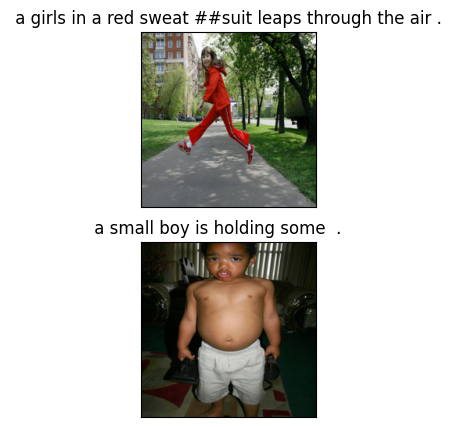

In [ ]:
def display_samples(path_images, path_captions):
  # display two images and their captions from the flicker8k dataset
  display_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        ])

  display_loader, display_dataset = get_loader(path_images,path_captions,batch_size=2,transform=display_transform)
  display_iter = iter(display_loader)
  images, captions, ids = next(display_iter)
  fig, axes = plt.subplots(len(images),1, figsize=(2.5,5))
  for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(" ".join([display_dataset.vocab.itos[t.item()] for t in captions[:,idx]]))
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

display_samples(path_images, path_captions)

In [ ]:
def create_transform(split):
  """
  defined the transformations needed to be done on an image before it goes
  into the model
  """

  if split == 'test':
    transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
          ])
  else:
    transform = transforms.Compose([
          transforms.Resize((226, 226)),
          transforms.RandomCrop((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
          ])

  return transform

In [ ]:
def create_loader(path_images, path_captions, split=''):
  """
  Create a data loader for the Flickr8k dataset based on the specified paths and split.

  Parameters:
  - path_images: The path to the directory containing the images.
  - path_captions: The path to the file containing the captions.
  - split: The split of the dataset to load ('train', 'test').

  Returns:
  - loader: The data loader for the Flickr8k dataset.
  """
  transform = create_transform(split)
  return get_loader(root_folder=path_images,annotation_file=path_captions,transform=transform,split=split)

In [ ]:
# creates the transforms and the loaders for the LSTM and GRU models.
transform_LSTM_Test = create_transform(split='test')
transform_LSTM_Train = create_transform(split='train')
transform_GRU_Test = create_transform(split='test')
transform_GRU_Train = create_transform(split='train')

train_loader_LSTM, train_dataset_LSTM = create_loader(path_images, path_captions, split='train')
train_loader_GRU, train_dataset_GRU = create_loader(path_images, path_captions, split='train')

total_loader_LSTM, total_dataset_LSTM = create_loader(path_images, path_captions)
total_loader_GRU, total_dataset_GRU = create_loader(path_images, path_captions)

test_loader_LSTM, test_dataset_LSTM = create_loader(path_images, path_captions, split='test')
test_loader_GRU, test_dataset_GRU = create_loader(path_images, path_captions, split='test')

In [101]:
# the enocder architecture. shared for both the LSTM and the GRU.
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.resnet(images)
        return self.dropout(self.relu(features))

# Decoder LSTM architecture
class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderLSTM, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

# encoder decoder with LSTM decoder
class CNNtoLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoLSTM, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.DecoderLSTM = DecoderLSTM(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.DecoderLSTM(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.DecoderLSTM.lstm(x, states)
                output = self.DecoderLSTM.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.DecoderLSTM.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "" or vocabulary.itos[predicted.item()] == ".":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

# Decoder GRU architecture
class DecoderGRU(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderGRU, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

# encoder decoder with LSTM decoder
class CNNtoGRU(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoGRU, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.DecoderGRU = DecoderGRU(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.DecoderGRU(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.DecoderGRU.lstm(x, states)
                output = self.DecoderGRU.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.DecoderGRU.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "" or vocabulary.itos[predicted.item()] == '.':
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [ ]:
# optuna for LSTM
def objective(trial):
    # Sample hyperparameters to explore from Optuna's suggestion
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam'])

    LSTM_hyperparam_optuna = Hyperparameters(embed_size=768, hidden_size=256, vocab_size=len(train_dataset_LSTM.vocab), num_layers=1, learning_rate=3e-4, num_epochs=2)

    #train
    cudnn_benchmark=True
    torch.backends.cudnn.benchmark = cudnn_benchmark
    losses = []
    load_model = False
    # Hyperparameters
    hyper = LSTM_hyperparam_optuna

    embed_size = hyper.embed_size
    hidden_size = hyper.hidden_size
    vocab_size = hyper.vocab_size
    num_layers = hyper.num_layers
    #learning_rate = hyper.learning_rate
    num_epochs = hyper.num_epochs

    dataset = train_dataset_LSTM
    # initialize model, loss etc
    model = CNNtoGRU(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi[""])

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    start_epoch = 1
    model.train()
    save_model = False
    cudnn_benchmark=True
    augmentations = None

    for epoch in range(num_epochs+1)[start_epoch:]:
        for idx, (imgs, captions,_) in tqdm(
            enumerate(train_loader_LSTM), total=len(train_loader_LSTM), leave=True, position=0
        ):

          imgs = imgs.to(device)
          captions = captions.to(device)
          if not augmentations is None:
            imgs = augmentations(imgs)
          outputs = model(imgs, captions[:-1])
          loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
          optimizer.zero_grad()
          loss.backward(loss)
          optimizer.step()
          losses.append(loss.item())
        print(f"Epoch {epoch} - Loss = {loss.item()}")
        accuracy = loss

        trial.report(accuracy, epoch)

        if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

    return accuracy


sampler = optuna.samplers.TPESampler()
study = optuna.create_study(direction='minimize', sampler= sampler)  #'minimize' because we want to minimize the loss
study.optimize(objective, n_trials=15, timeout=5000)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]


print("Study statistics: ")
print(" Number of finished trials: ", len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
 print(" {}: {}".format(key, value))

In [ ]:
# optuna for GRU
def objective(trial):
    # Sample hyperparameters to explore from Optuna's suggestion
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam'])

    GRU_hyperparam_optuna = Hyperparameters(embed_size=768, hidden_size=256, vocab_size=len(train_dataset_GRU.vocab), num_layers=1, learning_rate=3e-4, num_epochs=2)

    #train
    cudnn_benchmark=True
    torch.backends.cudnn.benchmark = cudnn_benchmark
    losses = []
    load_model = False
    # Hyperparameters
    hyper = GRU_hyperparam_optuna

    embed_size = hyper.embed_size
    hidden_size = hyper.hidden_size
    vocab_size = hyper.vocab_size
    num_layers = hyper.num_layers
    #learning_rate = hyper.learning_rate
    num_epochs = hyper.num_epochs

    dataset = train_dataset_GRU
    # initialize model, loss etc
    model = CNNtoGRU(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi[""])

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    start_epoch = 1
    model.train()
    save_model = False
    cudnn_benchmark=True
    augmentations = None

    for epoch in range(num_epochs+1)[start_epoch:]:
        for idx, (imgs, captions,_) in tqdm(
            enumerate(train_loader_GRU), total=len(train_loader_GRU), leave=True, position=0
        ):

          imgs = imgs.to(device)
          captions = captions.to(device)
          if not augmentations is None:
            imgs = augmentations(imgs)
          outputs = model(imgs, captions[:-1])
          loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
          optimizer.zero_grad()
          loss.backward(loss)
          optimizer.step()
          losses.append(loss.item())
        print(f"Epoch {epoch} - Loss = {loss.item()}")
        accuracy = loss

        trial.report(accuracy, epoch)

        if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

    return accuracy


sampler = optuna.samplers.TPESampler()
study = optuna.create_study(direction='minimize', sampler= sampler)  #'minimize' because we want to minimize the loss
study.optimize(objective, n_trials=15, timeout=5000)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]


print("Study statistics: ")
print(" Number of finished trials: ", len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
 print(" {}: {}".format(key, value))

In [ ]:
def train_model(model, train_loader, dataset, hyperparam , device, model_file='',save_model=True,train_CNN=False,load_model=False, cudnn_benchmark=True, augmentations = None):
    """
    Train the model using the provided data loader, dataset and hyperparameters.

    Parameters:
    - model: The model to train ('LSTM' or 'GRU').
    - train_loader: The data loader for training.
    - dataset: The dataset for training.
    - hyperparam: The hyperparameters for training.
    - device: The device to use for training
    - model_file: The filename to save the trained model checkpoint. Defaults to an empty string.
    - save_model: Whether to save the trained model checkpoint. Defaults to True.
    - train_CNN: Whether to train the CNN. Defaults to False.
    - load_model: Whether to load a pre-trained model checkpoint. Defaults to False.
    - cudnn_benchmark: Whether to use CuDNN benchmarking. Defaults to True.
    - augmentations: Image augmentations to apply during training. Defaults to None.

    Returns:
    - losses: A list of training losses for each epoch.
    """
    torch.backends.cudnn.benchmark = cudnn_benchmark
    losses = []

    # if load_model = True load the checkpoint, otherwise use the hyperparameters given.
    hyper = hyperparam
    if load_model:
      hyper = load_hyperparams(path_checkpoints+model_file, device)

    embed_size = hyper.embed_size
    hidden_size = hyper.hidden_size
    vocab_size = hyper.vocab_size
    num_layers = hyper.num_layers
    learning_rate = hyper.learning_rate
    num_epochs = hyperparam.num_epochs

    if model == 'LSTM':
      model = CNNtoLSTM(embed_size, hidden_size, vocab_size, num_layers).to(device)
    else:
      model = CNNtoGRU(embed_size, hidden_size, vocab_size, num_layers).to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi[""])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # train the CNN if train_CNN is True.
    for name, param in model.encoderCNN.resnet.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN

    start_epoch = 1
    if load_model:
        start_epoch, losses_loaded = load_checkpoint(path_checkpoints+model_file, model, optimizer, device)
        start_epoch += 1
        losses = losses_loaded
    model.train()

    for epoch in range(num_epochs+1)[start_epoch:]:
        # Uncomment the line below to see a couple of test cases
        # print_examples(model, device, dataset)

        for idx, (imgs, captions,_) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=True, position=0
        ):

            imgs = imgs.to(device)
            captions = captions.to(device)
            if not augmentations is None:
              imgs = augmentations(imgs)
            outputs = model(imgs, captions[:-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
        losses.append(loss.item())
        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "losses": losses,
                "hyperparams": hyper
            }
            save_checkpoint(checkpoint, path_checkpoints+model_file)
        print(f"Epoch {epoch} - Loss = {loss.item()}")
    return losses

In [ ]:
aug_list = AugmentationSequential(
    K.RandomHorizontalFlip(p=0.5), # Horizontal Flip mostly will not change the caption
    K.RandomAffine(5, [0.05, 0.05], [0.95, 1.05], p=.5), # Preforms random affine transformation (rotation, translation, scale).
    # up to 5 degrees of rotation, small translation and small scale
    K.RandomGaussianNoise(mean=0.0, std=0.1, p=0.5), # add low gaussian Noise to the image
    same_on_batch=False
)

In [ ]:
# train the LSTM model
LSTM_hyperparam = Hyperparameters(embed_size=768, hidden_size=256, vocab_size=len(train_dataset_LSTM.vocab), num_layers=1, learning_rate=0.002799, num_epochs=40)
losses_LSTM = train_model_pretrained('LSTM',train_loader_LSTM, train_dataset_LSTM, LSTM_hyperparam, device, model_file="LSTM_ckpt.pth", load_model=False, augmentations=aug_list)

In [ ]:
# train the GRU model
GRU_hyperparam = Hyperparameters(embed_size=768, hidden_size=256, vocab_size=len(train_dataset_GRU.vocab), num_layers=1, learning_rate=0.001038, num_epochs=40)
losses_GRU = train_model_pretrained('GRU', train_loader_GRU, train_dataset_GRU, GRU_hyperparam, device, model_file="GRU_ckpt.pth", load_model=False, augmentations=aug_list)

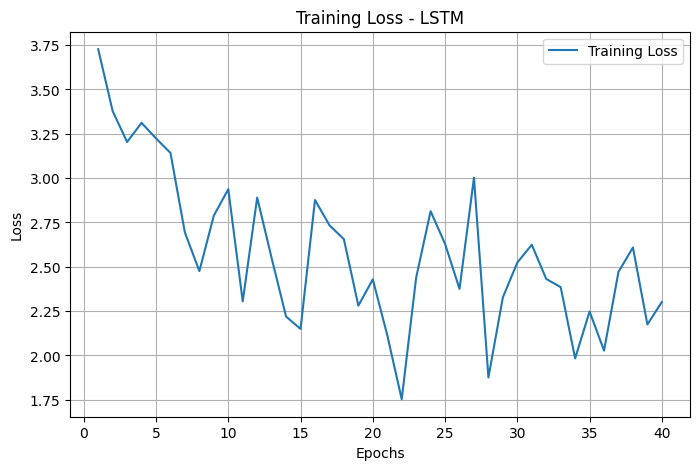

In [94]:
# plot the LSTM loss graph
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1 ,1)
ax.plot(range(len(losses_LSTM))+np.ones(len(losses_LSTM)),losses_LSTM, label="Training Loss")
ax.set_xlabel('Epochs')
ax.set_ylabel("Loss")
ax.set_title("Training Loss - LSTM")
ax.grid()
ax.legend()

plt.savefig("loss_LSTM.png")

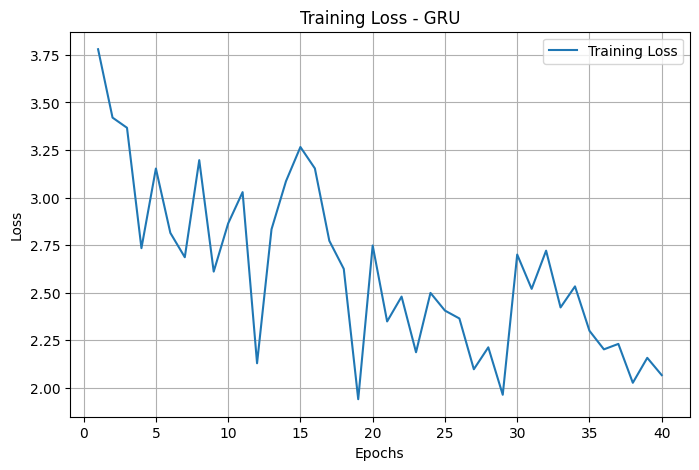

In [ ]:
# plot the GRU loss graph
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1 ,1)
ax.plot(range(len(losses_GRU))+np.ones(len(losses_GRU)),losses_GRU, label="Training Loss")
ax.set_xlabel('Epochs')
ax.set_ylabel("Loss")
ax.set_title("Training Loss - GRU")
ax.grid()
ax.legend()

plt.savefig("loss_GRU.png")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=> Loading checkpoint


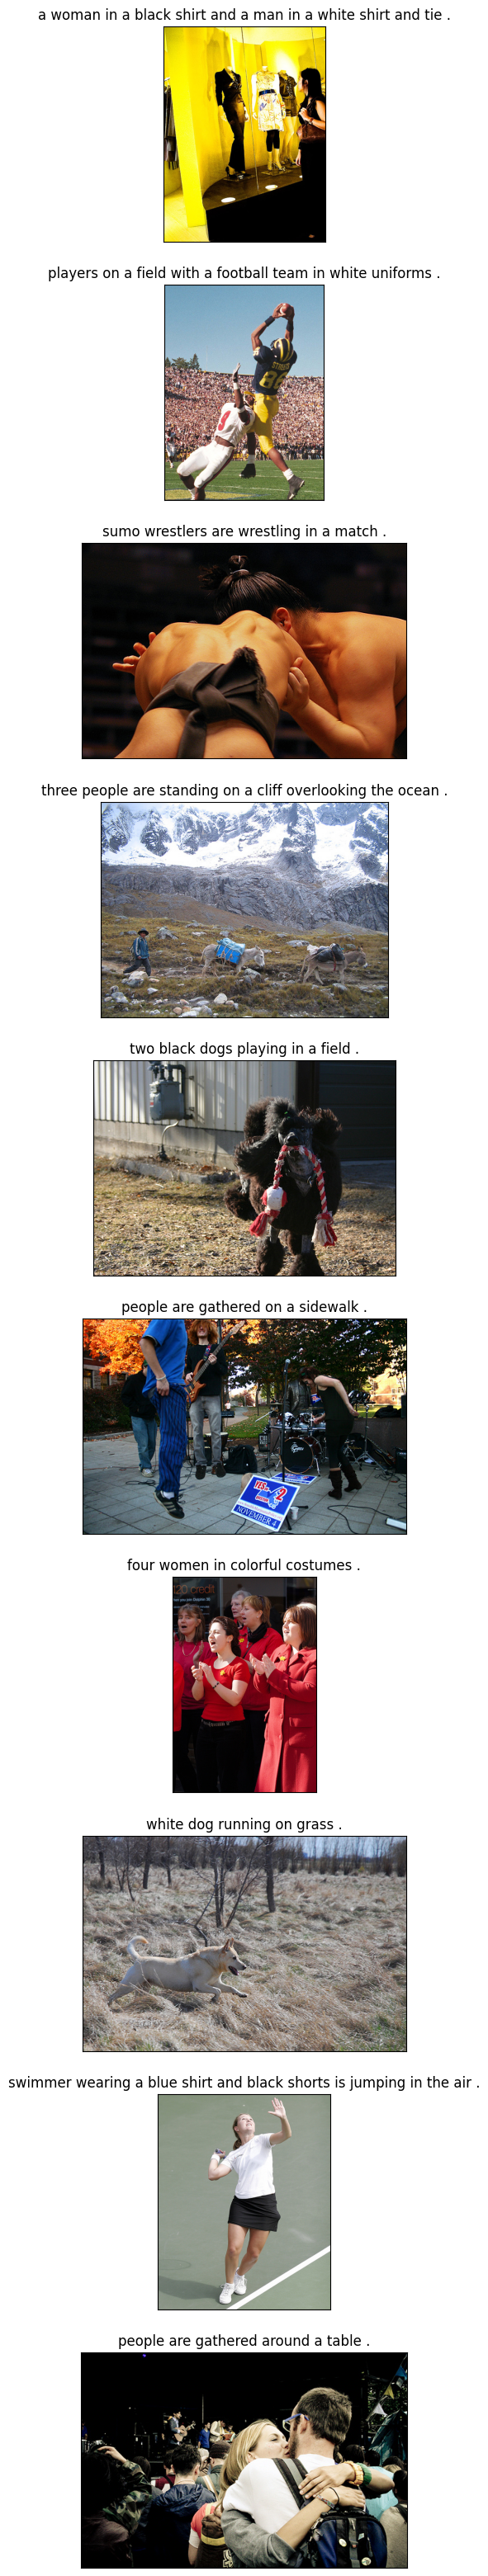

In [102]:
# show 5 captioned images by the LSTM model
LSTM_hyperparam = load_hyperparams(path_checkpoints+"/LSTM_ckpt.pth", device)
model = CNNtoLSTM(LSTM_hyperparam.embed_size, LSTM_hyperparam.hidden_size, LSTM_hyperparam.vocab_size, LSTM_hyperparam.num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=LSTM_hyperparam.learning_rate)
load_checkpoint(path_checkpoints+"LSTM_ckpt.pth", model, optimizer, device)
print_examples(model, device, test_dataset_LSTM,path_examples, transform_LSTM_Test, max_imgs=10, save=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=> Loading checkpoint


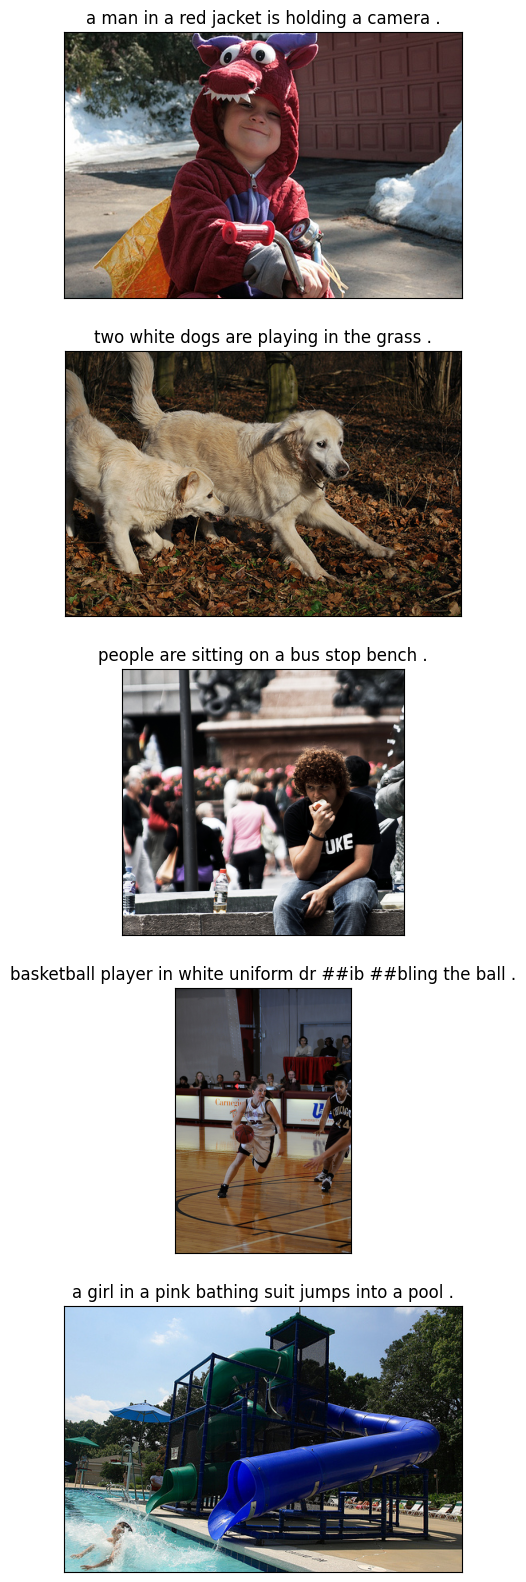

In [ ]:
# show 5 captioned images by the GRU model
GRU_hyperparam = load_hyperparams(path_checkpoints+"/GRU_ckpt.pth", device)
model = CNNtoGRU(GRU_hyperparam.embed_size, GRU_hyperparam.hidden_size, GRU_hyperparam.vocab_size, GRU_hyperparam.num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=GRU_hyperparam.learning_rate)
load_checkpoint(path_checkpoints+"GRU_ckpt.pth", model, optimizer, device)
print_examples(model, device, test_dataset_GRU,path_examples, transform_GRU_Test, max_imgs=5, save=True)

In [95]:
calc_bleu(test_loader_GRU, model, test_dataset_GRU, device, path_images, path_captions, transform_GRU_Test, num_batches=100)

  8%|▊         | 100/1265 [03:06<36:13,  1.87s/it]


0.14163690481368696

In [99]:
calc_bleu(test_loader_LSTM, model, test_dataset_LSTM, device, path_images, path_captions, transform_LSTM_Test, num_batches=100)

  8%|▊         | 100/1265 [03:08<36:32,  1.88s/it]


0.14541874646584285

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [106]:
!pip freeze > requirements.txt
!pip list --format=freeze > requirements.txt